In [1]:
from src.plot_utils import plot_xy_specifyBound
import numpy as np
import torch
from src.DEFAULTS import DEFAULT_mean_func, normalZ, Upper_quant, Lower_quant, DEFAULT_hetero_sigma
import matplotlib.pyplot as plt
from data_utils import GENERATE_hetero_noise, splitter
from src.kernel_methods import kernel_estimator
from src.models import vanilla_predNet, MC_dropnet
import torch
from src.losses import *


mean_func = lambda x : 4*np.sin(x/15 * 2 * np.pi)
sigma_func = lambda x : np.clip(0.2 *x *np.abs(np.sin(x)), 0.1, 20)
quant_lo = 0.025
quant_up = 0.975




_, _, train_Y, train_X = GENERATE_hetero_noise(
    n_points = 20000,
    mean_func = mean_func,
    std_fun = sigma_func
)

recal_mean, recal_std, recal_Y, recal_X = GENERATE_hetero_noise(
    n_points = 4000,
    mean_func = mean_func,
    std_fun = sigma_func
)
test_mean, test_std, test_Y, test_X = GENERATE_hetero_noise(
    n_points = 1000,
    mean_func = mean_func,
    std_fun = sigma_func
)



In [2]:
pred_model = vanilla_predNet(
            n_input = 1,
            hidden_layers = [100,50],
            n_output = 1,
            device = torch.device('cuda'))

train_X = torch.Tensor(train_X).view(-1,1).cuda()
train_Y = torch.Tensor(train_Y).cuda()
len_train = int(len(train_X)*0.8)

tr_idx, val_idx = splitter(len_train, len(train_Y) - len_train)
pred_model.train(
    
    train_X[tr_idx], train_Y[tr_idx], 
    train_X[val_idx], train_Y[val_idx], 
    bat_size = 64,
    LR = 5E-3,
    Decay = 1E-4,
    N_Epoch = 200,
    validate_times = 20,
    verbose = True,
    train_loss = mse_loss,
    val_loss_criterias = {
        
        "mse" : mse_loss,
        "rmse": rmse_loss
    },
    early_stopping = True,
    patience = 20,
    monitor_name = "rmse",
)




epoch  0
     loss: mse, 3.0783023834228516
     loss: rmse, 1.7545092105865479
epoch  10
     loss: mse, 1.9196245670318604
     loss: rmse, 1.385505199432373
epoch  20
     loss: mse, 1.7188769578933716
     loss: rmse, 1.3110594749450684
epoch  30
     loss: mse, 1.6726043224334717
     loss: rmse, 1.2932920455932617
epoch  40
     loss: mse, 1.7899458408355713
     loss: rmse, 1.3378885984420776
Early Stopped at Epoch  46


In [3]:
nll_model = MC_dropnet(
            n_input = 1,
            hidden_layers = [100,50],
            drop_rate = 0.,
            n_output = 2,
            device = torch.device('cuda'))

nll_model.train(
    
    train_X[tr_idx], train_Y[tr_idx], 
    train_X[val_idx], train_Y[val_idx], 
    bat_size = 64,
    LR = 1E-2,
    Decay = 1E-4,
    N_Epoch = 200,
    validate_times = 20,
    verbose = True,
    train_loss = mean_std_norm_loss,
    val_loss_criterias = {
        
        "nll" : mean_std_norm_loss,
        "rmse": rmse_loss
    },
    early_stopping = True,
    patience = 30,
    monitor_name = "rmse",
)

epoch  0
     loss: nll, 0.9014909863471985
     loss: rmse, 1.9725172519683838
epoch  10
     loss: nll, 0.4791406989097595
     loss: rmse, 1.4918522834777832
epoch  20
     loss: nll, 0.3301893174648285
     loss: rmse, 1.3035869598388672
epoch  30
     loss: nll, 0.3763939440250397
     loss: rmse, 1.4665279388427734
epoch  40
     loss: nll, 0.3103885352611542
     loss: rmse, 1.2943098545074463
epoch  50
     loss: nll, 0.3256480097770691
     loss: rmse, 1.3130836486816406
Early Stopped at Epoch  57


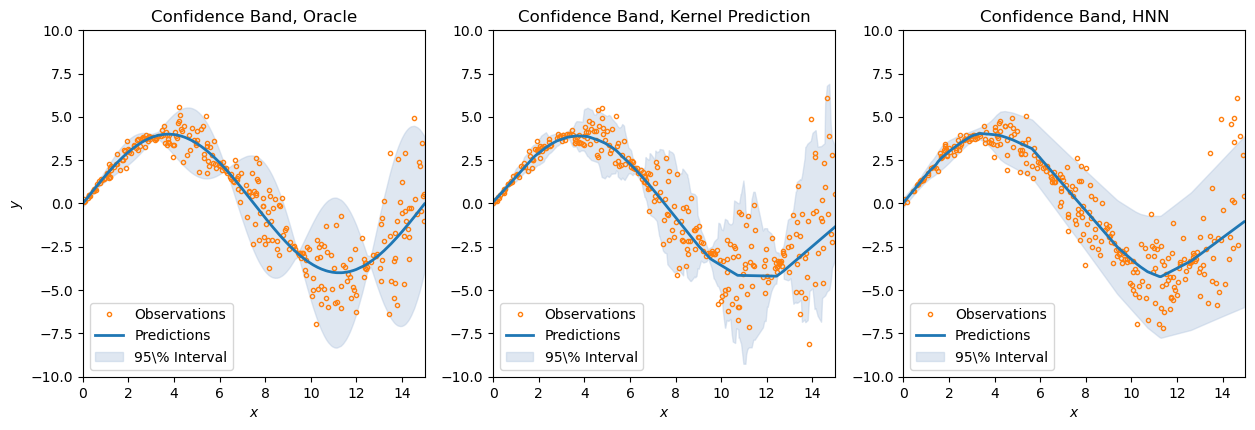

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 4.5))

test_Y_UP = test_mean + test_std * normalZ.ppf(quant_up)
test_Y_LO = test_mean + test_std * normalZ.ppf(quant_lo)

plot_xy_specifyBound(
    y_pred = test_mean,

    y_UP = test_Y_UP,
    y_LO = test_Y_LO,

    y_true = test_Y,
    x = test_X,
    n_subset = 300,

    ylims = [-10, 10],
    xlims = [0, 15],

    ax = ax1,
    title = "Confidence Band, Oracle"
)



recal_mean = pred_model(torch.Tensor(recal_X).view(-1,1).cuda()).view(-1).detach().cpu().numpy()
pred_test_mean = pred_model(torch.Tensor(test_X).view(-1,1).cuda()).view(-1).detach().cpu().numpy()

Y_LO_pred, Y_UP_pred = kernel_estimator(
    test_Z = torch.Tensor(test_X).view(-1, 1).cuda(),
    recal_Z = torch.Tensor(recal_X).view(-1, 1).cuda(),
    recal_epsilon = torch.Tensor(recal_Y - recal_mean).cuda(),
    quants = [quant_lo, quant_up]
).cpu().numpy()

plot_xy_specifyBound(
    y_pred = pred_test_mean,

    y_UP = Y_UP_pred + pred_test_mean,
    y_LO = Y_LO_pred + pred_test_mean,

    y_true = test_Y,
    x = test_X,
    n_subset = 300,

    ylims = [-10, 10],
    xlims = [0, 15],

    ax = ax2,
    title = "Confidence Band, Kernel Prediction",
    y_label = ""
)

preds = nll_model(torch.Tensor(test_X).view(-1,1).cuda()).detach().cpu().numpy()
nll_mean_pred = preds[:, 0]
nll_sigma_pred = preds[:, 1]

nll_test_Y_UP = nll_mean_pred + nll_sigma_pred * normalZ.ppf(quant_up)
nll_test_Y_LO = nll_mean_pred + nll_sigma_pred * normalZ.ppf(quant_lo)


plot_xy_specifyBound(
    y_pred = nll_mean_pred,

    y_UP = nll_test_Y_UP,
    y_LO = nll_test_Y_LO,

    y_true = test_Y,
    x = test_X,
    n_subset = 300,

    ylims = [-10, 10],
    xlims = [0, 15],

    ax = ax3,
    title = "Confidence Band, HNN",
    y_label = ""
)

plt.show()